---

<div align=center>

# **Initialisation**

</div>

### Dependencies

In [1]:
%%capture

import numpy as np
import tensorflow as tf
from LRFutils import archive, progress
import os
from multiprocess import Pool, cpu_count
import psutil
import pandas as pd
import matplotlib.pyplot as plt

2023-03-23 16:42:24.339387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 16:42:24.442166: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 16:42:26.750470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-23 16:42:26.750612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### Configuration

In [2]:
valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"

### Global variables

In [3]:
archive_path = archive.new()

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

### Useful functions

In [4]:
def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

---

<div align=center>

# **Load data**

</div>

### Data properties

In [5]:
def data_labels(x,y):
    """Take a vector of a dataset and return it's properties"""

    x_labels = [
        # "Dust Obs. Wavelenght [um]",
        "Dust Map",
        # "CO Velocity",
        # "CO Cube",
        # "N2H+ Velocity",
        # "N2H Cube"
    ]
    
    y_labels = ["Mass"]

    return x_labels, y_labels

### Read one file

In [6]:
def load_file(file):

    data = np.load(file)

    x = [
        # np.array(250), # dust observation frequency [um}
        data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        # data["CO_v"],
        # data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        # data["N2H_v"],
        # data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1) # adding a channel dimension
    ]
    
    y = [np.array(data["mass"]),]

    return x, y

### Load data

In [7]:
def load_data() -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Do what you want int this function, as long as it returns the following:
    - list[3D-ndarray] : input vectors
    - list[3D-ndarray] : output vectors
    """

    # Limit of the number of vectors to load
    max_files = 1000
    files = os.listdir(dataset_path)
    nb_vectors = min(len(files), max_files)

    # Load data
    x = []
    y = []
    bar = progress.Bar(nb_vectors, "Loading data")
    for i, file in enumerate(files):
        if i >= nb_vectors:
            break
        bar(i, prefix=system_info())
        
        new_x, new_y = load_file(f"{dataset_path}/{file}")
        x.append(new_x)
        y.append(new_y)
        
    bar(nb_vectors)    
    return x, y

In [8]:
x, y = load_data()
x_labels, y_labels = data_labels(x[0], y[0])
nb_vectors = len(x)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:033 eta 0:00:00


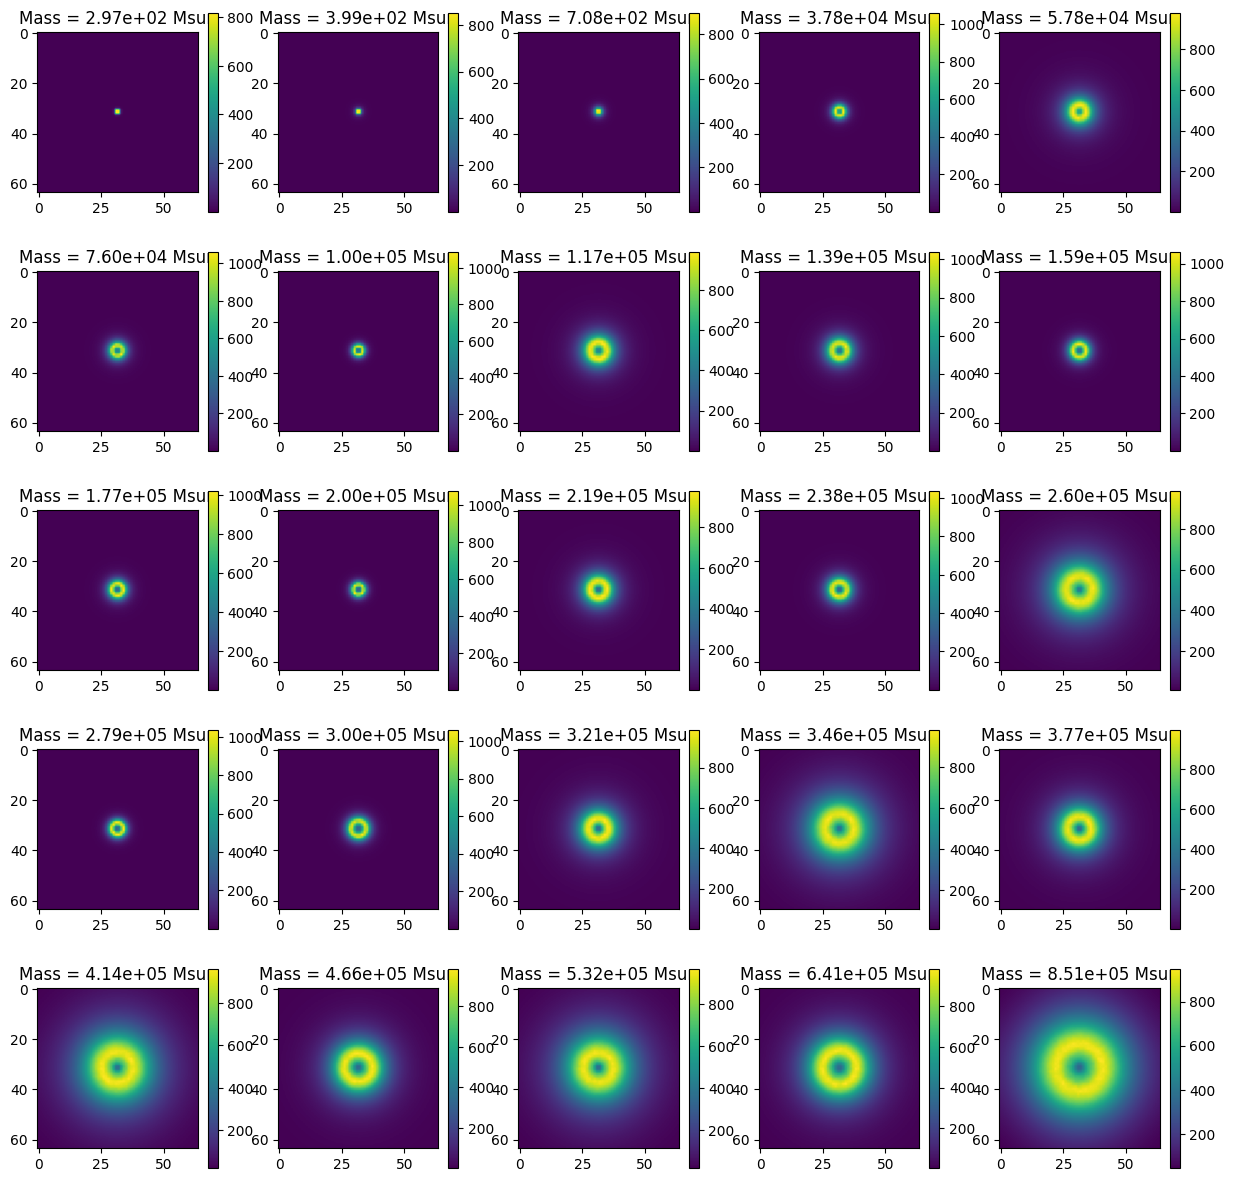

In [9]:
# Plot 25 random dust map

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# sort by mass
x_sorted = [x for _, x in sorted(zip(y, x))]
y_sorted = sorted(y)

for i in range(5):
    for j in range(5):
        # vec = np.random.randint(0, len(x)+1)
        vec = (i*5+j) * len(x)//25
        axs[i, j].set_title(f"Mass = {y_sorted[vec][0]:.2e} Msun")
        im = axs[i, j].imshow(x_sorted[vec][0])
        plt.colorbar(im)

In [10]:
# Plot 10 random complete input vector 

# fig, axs = plt.subplots(10, 4, figsize=(15, 15))

# for i in range(10):
#     vec = np.random.randint(0, len(x)+1)
#     print("----------")
#     print(len(x))
#     print(vec)
#     print(len(x[vec]))
#     axs[i, 0].imshow(x[vec][1])
#     axs[i, 1].plot(x[vec][2], label=r"CO $\nu$")
#     axs[i, 1].plot(x[vec][4], label=r"N2H+ $\nu$")
#     axs[i, 1].legend()
#     axs[i, 2].imshow(np.sum(x[vec][3], axis=(-1,-2)))
#     axs[i, 3].imshow(np.sum(x[vec][5], axis=(-1,-2)))

---

<div align=center>

# **Post processing**

</div>

### Normalisation

In [11]:
x_maxs = []
for element in x[0]:
    x_maxs.append(element.ravel()[0])

y_maxs = []
for element in y[0]:
    y_maxs.append(element.ravel()[0])

for vector in x:
    for i in range(len(vector)):
        if (value := np.max(np.abs(vector[i]))) > x_maxs[i]:
            x_maxs[i] = value

for i in range(len(x)):
    for j in range(len(vector)):
        x[i][j] /= x_maxs[j]

for vector in y:
    for i in range(len(vector)):
        if (value := np.max(np.abs(vector[i]))) > y_maxs[i]:
            y_maxs[i] = value

for i in range(len(y)):
    for j in range(len(vector)):
        y[i][j] /= y_maxs[j]

print("Maximum values:")
df = pd.DataFrame(np.matrix(x_maxs + y_maxs))
df.columns = x_labels + y_labels
df

Maximum values:


,Dust Map,Mass
0,1135.643311,2.103129e+06


### Splitting datasets
#### Train

In [12]:
train_frac = 1 - valid_frac - test_frac

train_x = x[:int(nb_vectors * train_frac)]
train_y = y[:int(nb_vectors * train_frac)]

df = pd.DataFrame(train_x)
df.columns = x_labels
df

,Dust Map
0,"[[[4.1887113e-05], [4.498622e-05], [4.842846e-..."
1,"[[[6.43483e-07], [7.0361295e-07], [7.682907e-0..."
2,"[[[3.6784208e-05], [3.989301e-05], [4.340301e-..."
3,"[[[0.000120179175], [0.00013024443], [0.000141..."
4,"[[[0.0006910026], [0.00073969294], [0.00078897..."
...,...
695,"[[[2.6115622e-08], [2.8407902e-08], [3.070984e..."
696,"[[[0.00014669835], [0.00015806915], [0.0001712..."
697,"[[[0.0028963902], [0.0030770928], [0.003263594..."
698,"[[[0.00011332128], [0.000121661506], [0.000131..."


In [13]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.0877102742914217
1,0.10980122393562577
2,0.16765300689887933
3,0.21208286162035447
4,0.14558566080079555
...,...
695,0.00017149633153355274
696,0.17621183107196586
697,0.14382296092485
698,0.12086902707229738


#### Validation

In [14]:
valid_x = x[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]
valid_y = y[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]

df = pd.DataFrame(valid_x)
df.columns = x_labels
df

,Dust Map
0,"[[[0.00021112313], [0.00022497503], [0.0002419..."
1,"[[[1.0564117e-06], [1.1462257e-06], [1.2457358..."
2,"[[[7.9004036e-07], [8.626817e-07], [9.4491503e..."
3,"[[[1.208285e-06], [1.2871589e-06], [1.3778368e..."
4,"[[[1.6882049e-06], [1.8045114e-06], [1.919371e..."
...,...
195,"[[[0.027488241], [0.028894998], [0.03033747], ..."
196,"[[[0.00019412581], [0.0002103607], [0.00022588..."
197,"[[[0.00025231435], [0.00027140573], [0.0002909..."
198,"[[[0.024111373], [0.025418859], [0.026631027],..."


In [15]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.0877102742914217
1,0.10980122393562577
2,0.16765300689887933
3,0.21208286162035447
4,0.14558566080079555
...,...
695,0.00017149633153355274
696,0.17621183107196586
697,0.14382296092485
698,0.12086902707229738


#### Test

In [16]:
test_x = x[int(nb_vectors * (train_frac + valid_frac)):]
test_y = y[int(nb_vectors * (train_frac + valid_frac)):]

df = pd.DataFrame(test_x)
df.columns = x_labels
df

,Dust Map
0,"[[[7.349336e-07], [8.031131e-07], [8.7742916e-..."
1,"[[[0.00025583015], [0.00027580856], [0.0002970..."
2,"[[[0.0071350015], [0.0074954135], [0.007887039..."
3,"[[[6.2575e-05], [6.756482e-05], [7.284774e-05]..."
4,"[[[0.0003866676], [0.0004169837], [0.000448488..."
...,...
95,"[[[1.403004e-07], [1.5338166e-07], [1.6783196e..."
96,"[[[9.620714e-06], [1.049303e-05], [1.1407497e-..."
97,"[[[0.004558639], [0.004818142], [0.005096308],..."
98,"[[[0.0008056798], [0.00086074375], [0.00092317..."


In [17]:
df = pd.DataFrame(train_y)
df.columns = y_labels
df

,Mass
0,0.0877102742914217
1,0.10980122393562577
2,0.16765300689887933
3,0.21208286162035447
4,0.14558566080079555
...,...
695,0.00017149633153355274
696,0.17621183107196586
697,0.14382296092485
698,0.12086902707229738


In [18]:
x = np.array([i[0] for i in x])
train_x = np.array([i[0] for i in train_x])
valid_x = np.array([i[0] for i in valid_x])
test_x = np.array([i[0] for i in test_x])
y = np.array([i[0] for i in y])
train_y = np.array([i[0] for i in train_y])
valid_y = np.array([i[0] for i in valid_y])
test_y = np.array([i[0] for i in test_y])

print(x.shape)
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(y.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(1000, 64, 64, 1)
(700, 64, 64, 1)
(200, 64, 64, 1)
(100, 64, 64, 1)
(1000,)
(700,)
(200,)
(100,)


---

<div align=center>

# **Model definition**

</div>

### Build model

In [19]:
def get_model(input_shape):
    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Reshape, Conv3DTranspose, Flatten
    from keras.models import Model

    # Définir la forme de l'image d'entrée
    input = Input(shape=input_shape)

    # Encoder
    # x = Conv2D(8, (5, 5), activation='relu', padding='same')(input)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Flatten()(x)
    # x = Dense(1024, activation='relu')(x)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='relu')(x)

    # Modèle d'auto-encodeur
    model = Model(input, output)

    return model

### Compile model and get summary

In [20]:
model = get_model(x[0].shape)

def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mean_squared_error'])

# Store and print model summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 524,545
Trainable params: 524,545
Non-trainable params: 0
_________________________________________________________________


2023-03-23 16:42:57.794535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-23 16:42:57.794563: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-23 16:42:57.795248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Human validation of the model

In [21]:
# choice = input("Continue ? [Y/n]")

# if choice.lower() not in ["", "y", "yes"]:
#     exit()

### Training model

In [52]:
history = model.fit(train_x, train_y, epochs=10000, batch_size=50, validation_data=(valid_x, valid_y), verbose=0)
model.save(f'{archive_path}/model0.h5')

TypeError: unsupported operand type(s) for +=: 'History' and 'History'

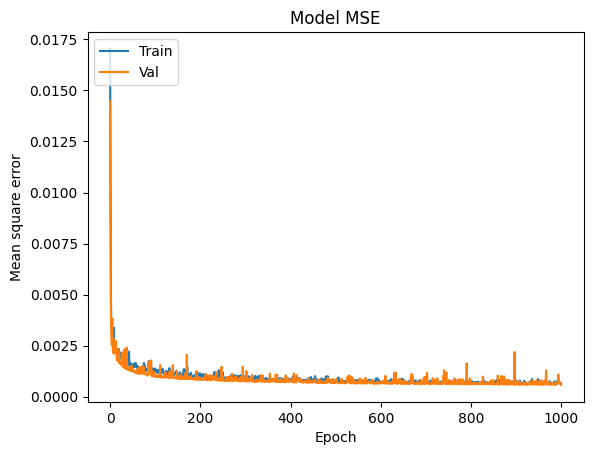

In [23]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('Mean square error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


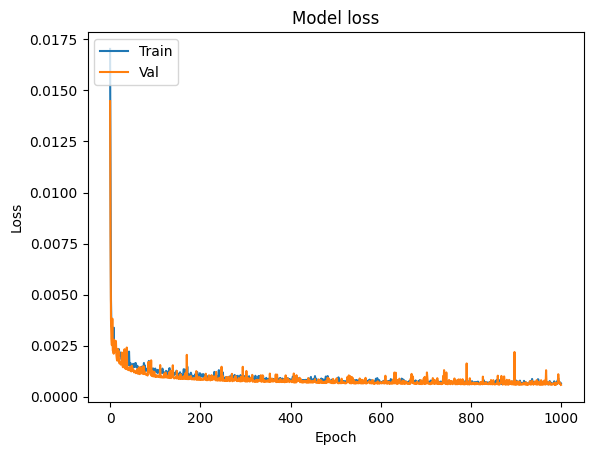

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Evaluating model

In [57]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Score:", score)

with open(f'{archive_path}/scores.txt', 'w') as f:
    f.write(f'Score:    \t{score}\n')

Score: [0.032046765089035034, 0.032046765089035034]


---

<div align=center>

# **Predictions**

</div>

In [56]:
r = np.random.randint(0, len(x)+1)
x_prediction = np.array([x[r]])
print(x_prediction.shape)

y_prediction = model.predict(x_prediction)[0,0]
print(y_prediction.shape)

print(f"Expected: {y[r] * y_maxs[0]:.2e} Msun")
print(f"Predicted: {y_prediction * y_maxs[0]:.2e} Msun")

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction)

(1, 64, 64, 1)
1/1 [==============================] - 0s 23ms/step
()
Expected: 3.19e+05 Msun
Predicted: 0.00e+00 Msun
